### 초기 경로 설정 (클래스 이용을 위함)

In [1]:
%cd /project/segmentation/smcho1201/segmentation_project

/project/segmentation/smcho1201/segmentation_project


In [2]:
# files and system
import os
import sys
import time
import random

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
from IPython.display import clear_output
# working with images
import cv2
import imageio
import scipy.ndimage
# import skimage.transform

import torchvision.transforms as transforms

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F


import torchsummary
from tqdm import notebook

sys.path.insert(0, '..')

# losses
from utils.metrics import iou_pytorch_eval, IoULoss, IoUBCELoss, DiceBCELoss , dice_pytorch_eval
from utils.metrics import iou_pytorch_test, dice_pytorch_test, precision_pytorch_test, recall_pytorch_test, fbeta_pytorch_test, accuracy_pytorch_test

# dataset
from utils.dataset import myDataSet

## 랜덤성을 배제한 환경 고정

In [3]:
random_seed= 42
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True

In [4]:
DEVICE = torch.device("cuda:1" if torch.cuda.is_available() else "cpu") # select device for training, i.e. gpu or cpu
print(DEVICE)

cuda:1


# 1. Image augentation
> 실험할 때는 아예 augmentation도 고정시켜서 저장한 이미지를 사용해야 함.

In [5]:
_size = 224, 224
resize = transforms.Resize(_size, interpolation=0)

# set your transforms 
train_transforms = transforms.Compose([
                           transforms.Resize(_size, interpolation=0),
                           transforms.RandomRotation(180),
                           transforms.RandomHorizontalFlip(0.5),
                           transforms.RandomCrop(_size, padding = 10), # needed after rotation (with original size)
                       ])

test_transforms = transforms.Compose([
                           transforms.Resize(_size, interpolation=0),
                       ])

/home/smcho1201/.conda/envs/pytorch/lib/python3.9/site-packages/torchvision/transforms/transforms.py:332: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


# 2. 데이터셋 클래스 생성
> 해당 클래스는 이용하려는 이미지와 라벨의 모든 경로(/data/segmentation/...)의 리스트를 인자로 받는다.   

In [6]:
train_images = glob.glob('/data/segmentation/CVC-ClinicDB/trainset/images/*')
train_labels = glob.glob('/data/segmentation/CVC-ClinicDB/trainset/labels/*')
train_images = [img for img in train_images if img.find('jpg')!= -1] # super pixels 이미지 제외

valid_images = glob.glob('/data/segmentation/CVC-ClinicDB/validationset/images/*')
valid_labels = glob.glob('/data/segmentation/CVC-ClinicDB/validationset/labels/*')
valid_images = [img for img in valid_images if img.find('jpg')!= -1] # super pixels 이미지 제외

train_images = sorted(train_images)
train_labels = sorted(train_labels)

valid_images = sorted(valid_images)
valid_labels = sorted(valid_labels)

# 데이터셋 클래스 적용
custom_dataset_train = myDataSet(train_images, train_labels, transforms=test_transforms)
print("My custom training-dataset has {} elements".format(len(custom_dataset_train)))

custom_dataset_val = myDataSet(valid_images, valid_labels, transforms=test_transforms)
print("My custom valing-dataset has {} elements".format(len(custom_dataset_val)))


My custom training-dataset has 366 elements
My custom valing-dataset has 123 elements


### dataset class check
> RGB 채널 평균 값이라 색 바뀜

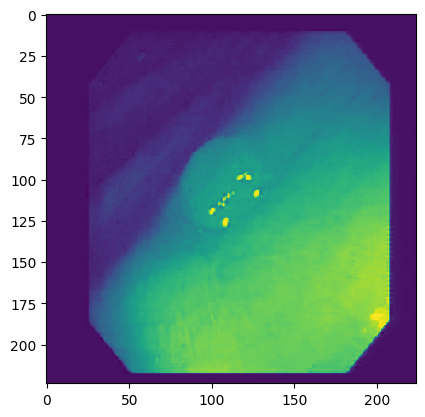

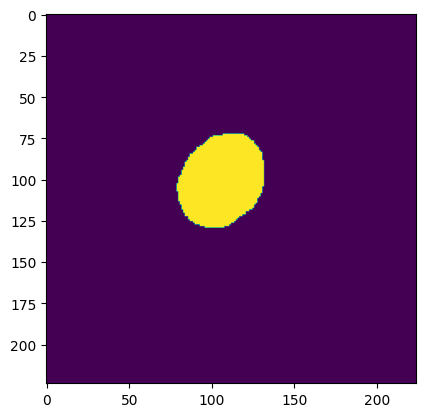

3픽셀의 평균값이라 색깔이 변경됨.


In [7]:
# Show example images.
image_number = 23
img, mask = custom_dataset_train.__getitem__(image_number)

# image
plt.figure()
plt.imshow(img.mean(0)) # 3 channels, take mean

# mask
plt.figure()
plt.imshow(mask[0, :, :]) # 1 channel, take it

plt.show()
print('3픽셀의 평균값이라 색깔이 변경됨.')

# 3. 모델 클래스 생성

In [8]:
# Begin training
from models.DeepLab_V3_p.model import DeepLab as DeepLab_V3_p
model = DeepLab_V3_p(backbone = 'resnet', num_classes = 1)   # backbone : 선택 (resnet, xception, mobilenet)
model = model.to(DEVICE) # load model to DEVICE

# 4. 하이퍼 파라미터 세팅 & 데이터 로더 생성

In [9]:
# Define variables for the training
epochs = 100
patience = 20
BATCH_SIZE = 8

dataloader_train = torch.utils.data.DataLoader(custom_dataset_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
dataloader_val = torch.utils.data.DataLoader(custom_dataset_val, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [10]:
# Define optimiser and criterion for the training. You can try different ones to see which works best for your data and task
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4, weight_decay = 1e-8)

criterion = DiceBCELoss()
model_name = 'DeepLab_V3+'
data_name = 'CVC'

# 5. Training

/home/smcho1201/.conda/envs/pytorch/lib/python3.9/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 Epoch: 1 of 100, Iter.: 46 of 46, Train Loss: 1.008972, IoU: 0.361049, Dice: 0.481850
 Epoch: 1 of 100, Iter.: 46 of 46, Valid Loss: 1.260477, IoU: 0.409904, Dice: 0.544517

시각화되는 이미지는 1.실제 테스트 이미지 2.실제 라벨 이미지 3.예측 라벨 4.예측한 이미지 결과의 순서입니다.


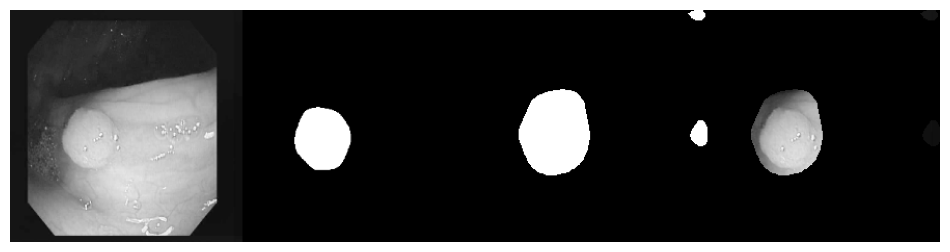

 Epoch: 2 of 100, Iter.: 46 of 46, Train Loss: 0.463546, IoU: 0.636687, Dice: 0.740787
 Epoch: 2 of 100, Iter.: 46 of 46, Valid Loss: 0.552403, IoU: 0.599219, Dice: 0.708619


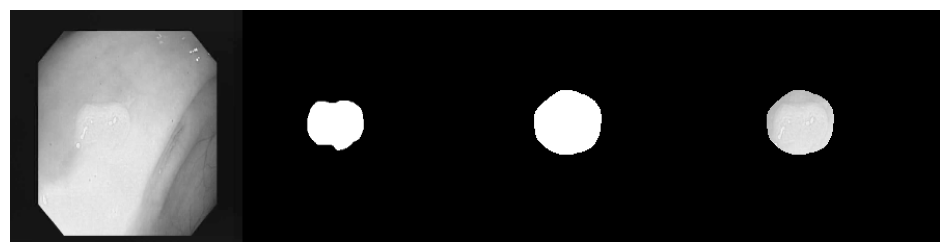

 Epoch: 3 of 100, Iter.: 46 of 46, Train Loss: 0.320573, IoU: 0.715369, Dice: 0.807347
 Epoch: 3 of 100, Iter.: 46 of 46, Valid Loss: 0.349315, IoU: 0.653647, Dice: 0.750903


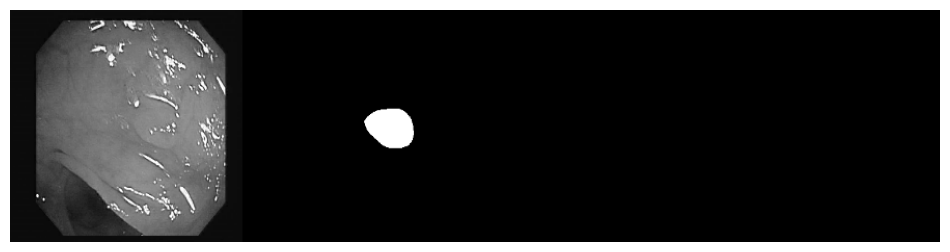

 Epoch: 4 of 100, Iter.: 46 of 46, Train Loss: 0.245333, IoU: 0.756338, Dice: 0.839046
 Epoch: 4 of 100, Iter.: 46 of 46, Valid Loss: 0.319165, IoU: 0.680917, Dice: 0.770440


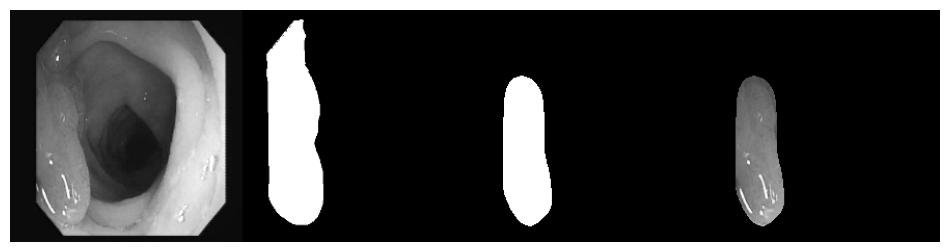

 Epoch: 5 of 100, Iter.: 46 of 46, Train Loss: 0.186796, IoU: 0.794331, Dice: 0.867127
 Epoch: 5 of 100, Iter.: 46 of 46, Valid Loss: 0.281229, IoU: 0.703804, Dice: 0.793798


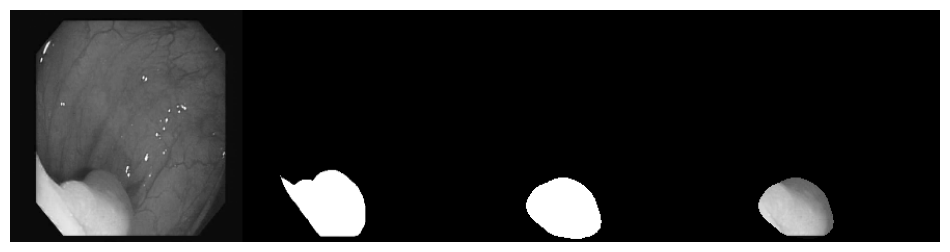

 Epoch: 6 of 100, Iter.: 46 of 46, Train Loss: 0.151015, IoU: 0.819524, Dice: 0.885216
 Epoch: 6 of 100, Iter.: 46 of 46, Valid Loss: 0.284306, IoU: 0.707594, Dice: 0.795295


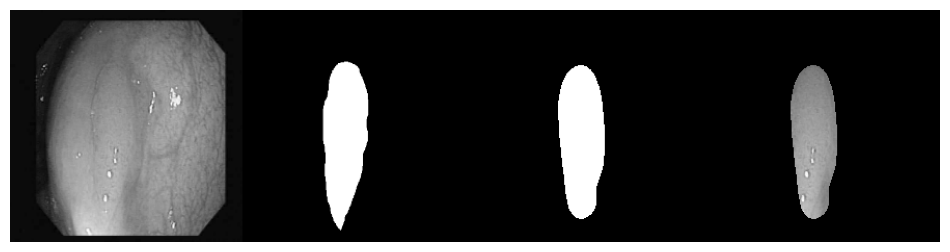

 Epoch: 7 of 100, Iter.: 46 of 46, Train Loss: 0.132002, IoU: 0.837262, Dice: 0.897002
 Epoch: 7 of 100, Iter.: 46 of 46, Valid Loss: 0.261297, IoU: 0.718870, Dice: 0.801453


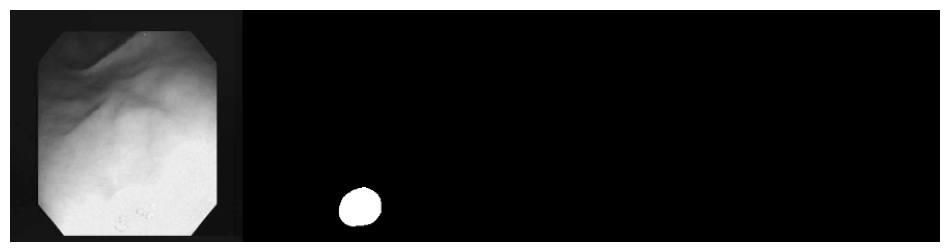

 Epoch: 8 of 100, Iter.: 46 of 46, Train Loss: 0.115982, IoU: 0.847821, Dice: 0.905992
 Epoch: 8 of 100, Iter.: 46 of 46, Valid Loss: 0.262498, IoU: 0.716999, Dice: 0.806176


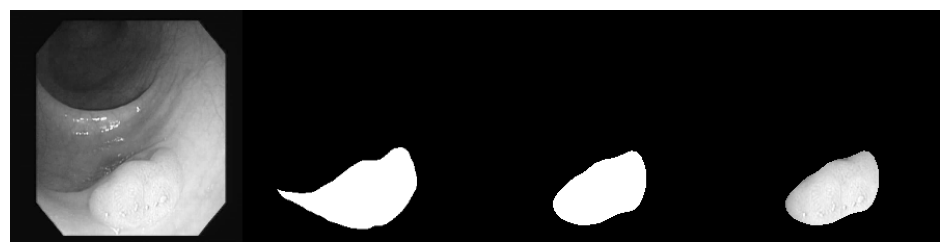

 Epoch: 9 of 100, Iter.: 46 of 46, Train Loss: 0.098863, IoU: 0.869008, Dice: 0.920150
 Epoch: 9 of 100, Iter.: 46 of 46, Valid Loss: 0.250503, IoU: 0.732182, Dice: 0.812104


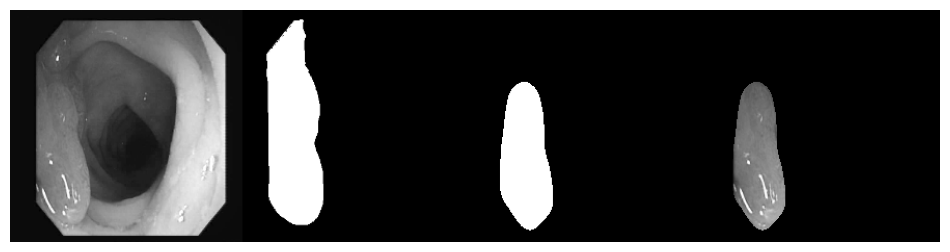

 Epoch: 10 of 100, Iter.: 46 of 46, Train Loss: 0.092034, IoU: 0.874272, Dice: 0.924018
 Epoch: 10 of 100, Iter.: 46 of 46, Valid Loss: 0.271676, IoU: 0.720590, Dice: 0.800716


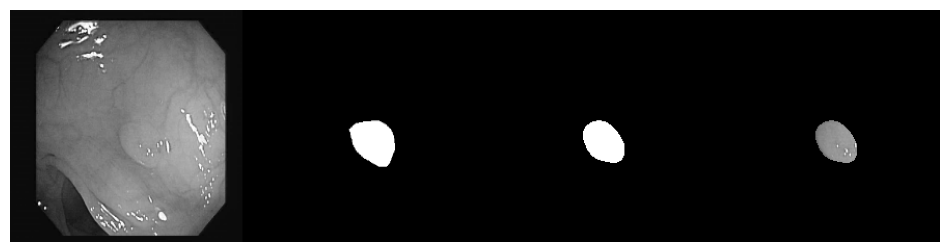

 Epoch: 11 of 100, Iter.: 46 of 46, Train Loss: 0.087388, IoU: 0.881923, Dice: 0.929307
 Epoch: 11 of 100, Iter.: 46 of 46, Valid Loss: 0.279976, IoU: 0.700837, Dice: 0.790990


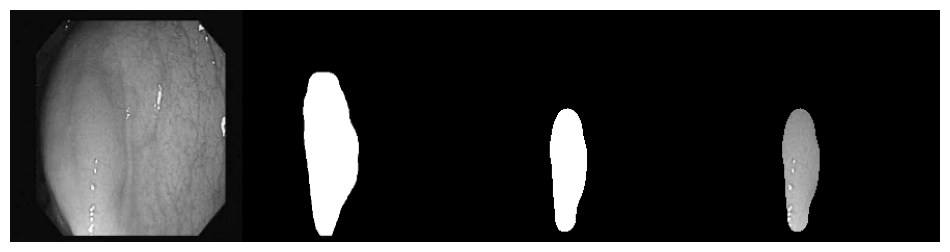

 Epoch: 12 of 100, Iter.: 46 of 46, Train Loss: 0.093080, IoU: 0.871899, Dice: 0.922372
 Epoch: 12 of 100, Iter.: 46 of 46, Valid Loss: 0.248252, IoU: 0.730105, Dice: 0.811631


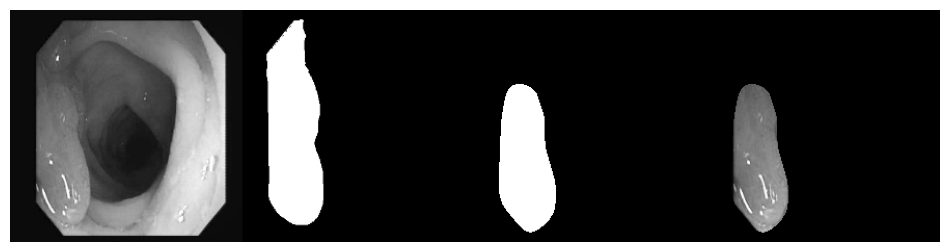

 Epoch: 13 of 100, Iter.: 46 of 46, Train Loss: 0.085556, IoU: 0.880665, Dice: 0.928367
 Epoch: 13 of 100, Iter.: 46 of 46, Valid Loss: 0.223650, IoU: 0.745948, Dice: 0.821711


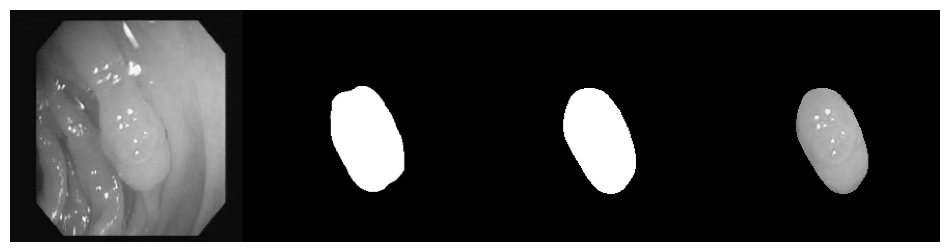

 Epoch: 14 of 100, Iter.: 46 of 46, Train Loss: 0.081887, IoU: 0.885154, Dice: 0.930881
 Epoch: 14 of 100, Iter.: 46 of 46, Valid Loss: 0.242842, IoU: 0.728525, Dice: 0.805192


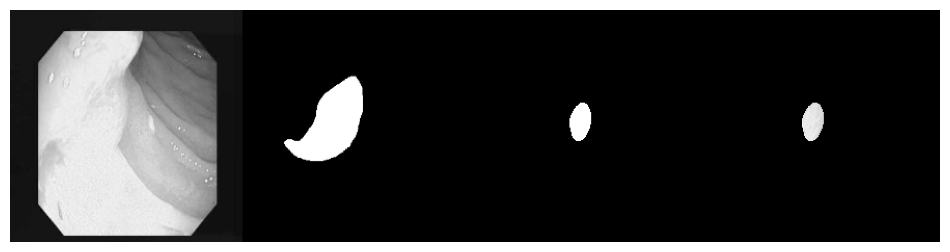

 Epoch: 15 of 100, Iter.: 46 of 46, Train Loss: 0.075239, IoU: 0.889353, Dice: 0.934046
 Epoch: 15 of 100, Iter.: 46 of 46, Valid Loss: 0.231711, IoU: 0.742442, Dice: 0.820658


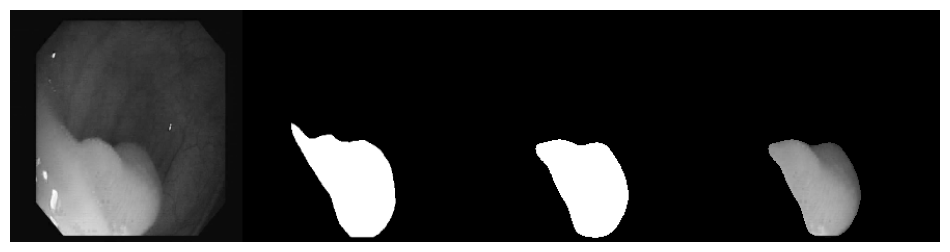

 Epoch: 16 of 100, Iter.: 46 of 46, Train Loss: 0.069610, IoU: 0.896011, Dice: 0.938303
 Epoch: 16 of 100, Iter.: 46 of 46, Valid Loss: 0.217615, IoU: 0.752725, Dice: 0.833412


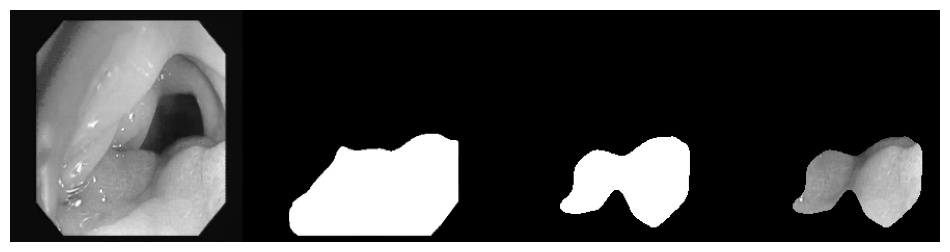

 Epoch: 17 of 100, Iter.: 46 of 46, Train Loss: 0.062257, IoU: 0.908178, Dice: 0.947217
 Epoch: 17 of 100, Iter.: 46 of 46, Valid Loss: 0.222682, IoU: 0.757045, Dice: 0.831810


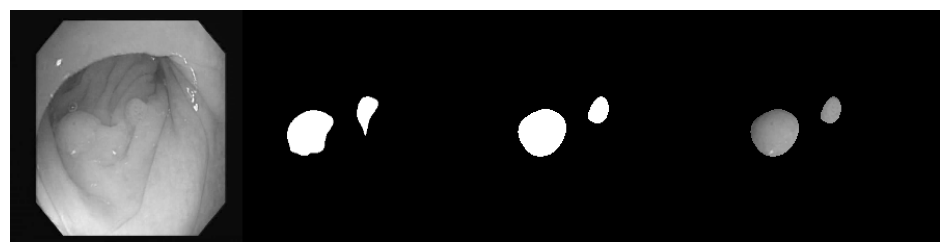

 Epoch: 18 of 100, Iter.: 46 of 46, Train Loss: 0.059847, IoU: 0.911678, Dice: 0.948462
 Epoch: 18 of 100, Iter.: 46 of 46, Valid Loss: 0.231047, IoU: 0.737224, Dice: 0.814668


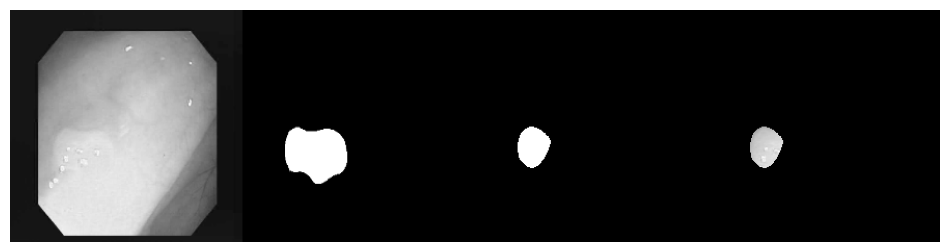

 Epoch: 19 of 100, Iter.: 46 of 46, Train Loss: 0.058949, IoU: 0.908581, Dice: 0.946877
 Epoch: 19 of 100, Iter.: 46 of 46, Valid Loss: 0.242595, IoU: 0.741099, Dice: 0.822436


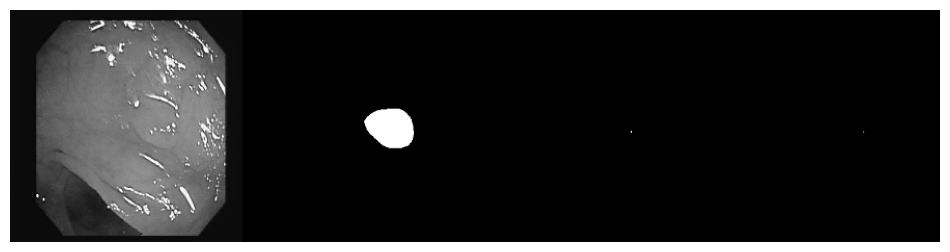

 Epoch: 20 of 100, Iter.: 46 of 46, Train Loss: 0.057011, IoU: 0.914939, Dice: 0.951211
 Epoch: 20 of 100, Iter.: 46 of 46, Valid Loss: 0.228929, IoU: 0.758732, Dice: 0.834340


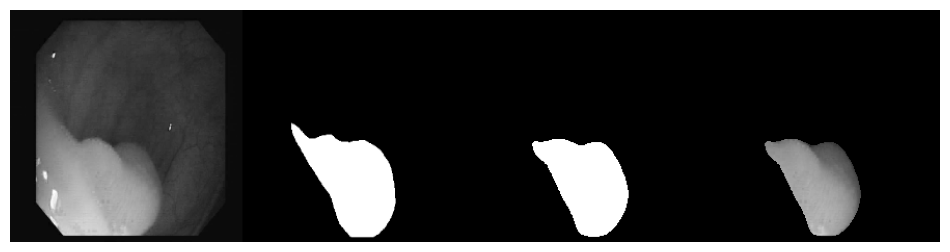

 Epoch: 21 of 100, Iter.: 46 of 46, Train Loss: 0.053879, IoU: 0.918013, Dice: 0.952868
 Epoch: 21 of 100, Iter.: 46 of 46, Valid Loss: 0.233470, IoU: 0.751342, Dice: 0.826181


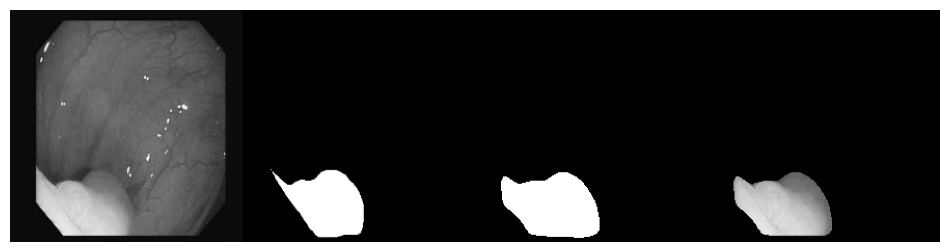

 Epoch: 22 of 100, Iter.: 46 of 46, Train Loss: 0.050275, IoU: 0.924342, Dice: 0.957313
 Epoch: 22 of 100, Iter.: 46 of 46, Valid Loss: 0.220807, IoU: 0.761211, Dice: 0.836611


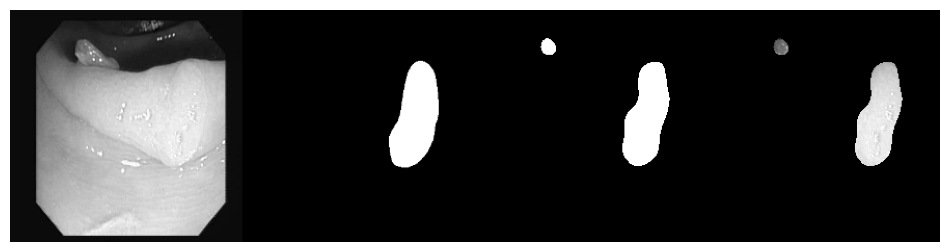

 Epoch: 23 of 100, Iter.: 46 of 46, Train Loss: 0.050925, IoU: 0.922497, Dice: 0.955782
 Epoch: 23 of 100, Iter.: 46 of 46, Valid Loss: 0.219250, IoU: 0.771081, Dice: 0.842454


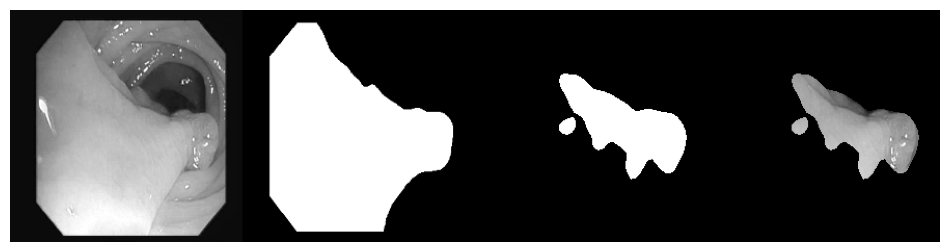

 Epoch: 24 of 100, Iter.: 46 of 46, Train Loss: 0.049605, IoU: 0.924442, Dice: 0.957849
 Epoch: 24 of 100, Iter.: 46 of 46, Valid Loss: 0.249877, IoU: 0.729700, Dice: 0.804552


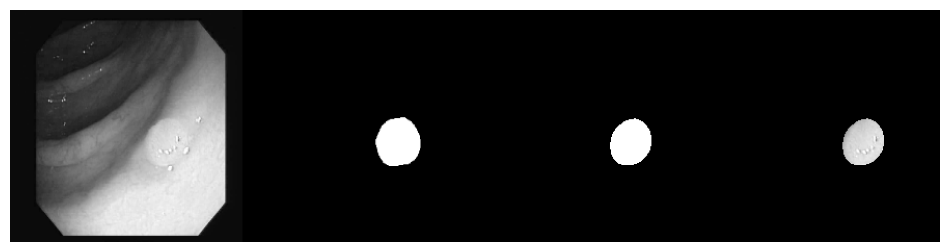

 Epoch: 25 of 100, Iter.: 46 of 46, Train Loss: 0.047552, IoU: 0.925846, Dice: 0.958361
 Epoch: 25 of 100, Iter.: 46 of 46, Valid Loss: 0.225561, IoU: 0.767248, Dice: 0.842406


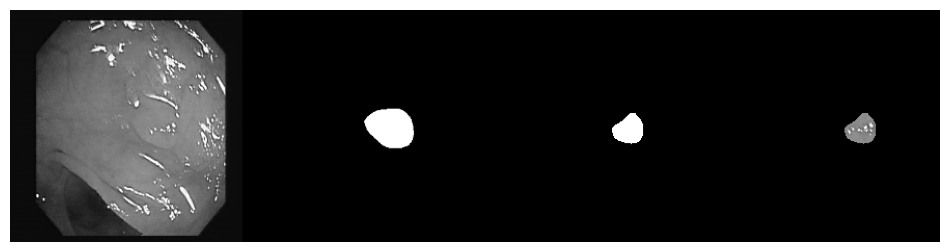

 Epoch: 26 of 100, Iter.: 46 of 46, Train Loss: 0.047460, IoU: 0.926014, Dice: 0.959173
 Epoch: 26 of 100, Iter.: 46 of 46, Valid Loss: 0.237134, IoU: 0.750498, Dice: 0.825204


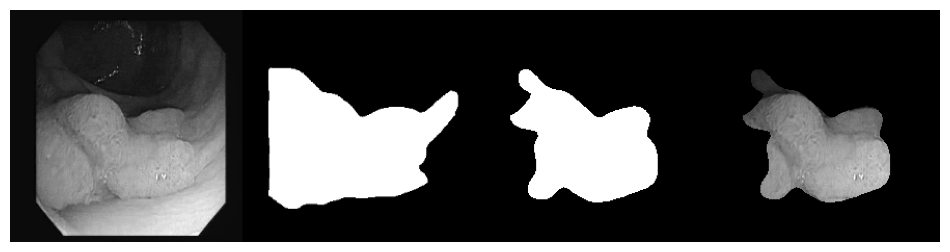

 Epoch: 27 of 100, Iter.: 46 of 46, Train Loss: 0.044273, IoU: 0.930499, Dice: 0.961091
 Epoch: 27 of 100, Iter.: 46 of 46, Valid Loss: 0.226241, IoU: 0.767000, Dice: 0.842611


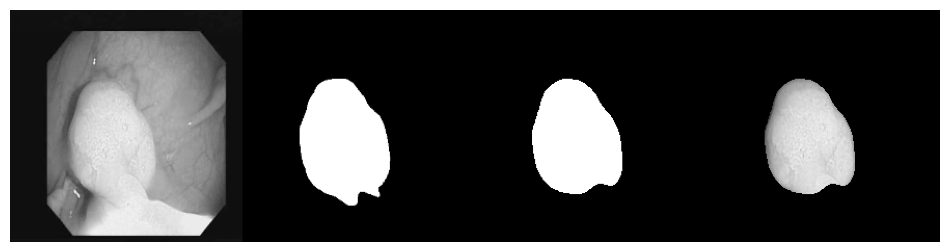

 Epoch: 28 of 100, Iter.: 46 of 46, Train Loss: 0.044040, IoU: 0.932249, Dice: 0.962414
 Epoch: 28 of 100, Iter.: 46 of 46, Valid Loss: 0.238915, IoU: 0.745982, Dice: 0.822457


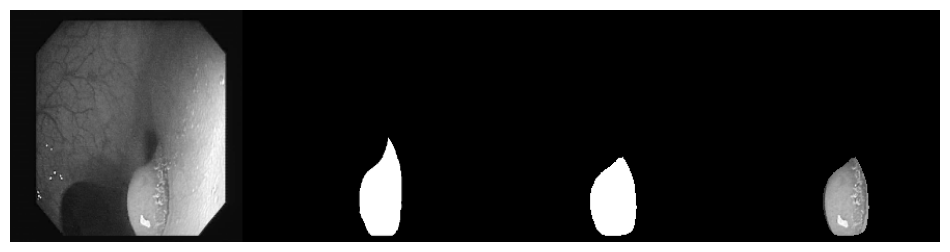

 Epoch: 29 of 100, Iter.: 46 of 46, Train Loss: 0.044440, IoU: 0.932254, Dice: 0.962752
 Epoch: 29 of 100, Iter.: 46 of 46, Valid Loss: 0.220984, IoU: 0.767579, Dice: 0.843637


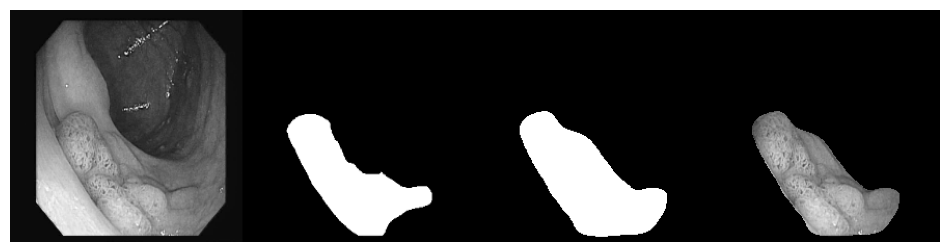

 Epoch: 30 of 100, Iter.: 46 of 46, Train Loss: 0.043873, IoU: 0.932629, Dice: 0.962708
 Epoch: 30 of 100, Iter.: 46 of 46, Valid Loss: 0.227359, IoU: 0.768716, Dice: 0.844488


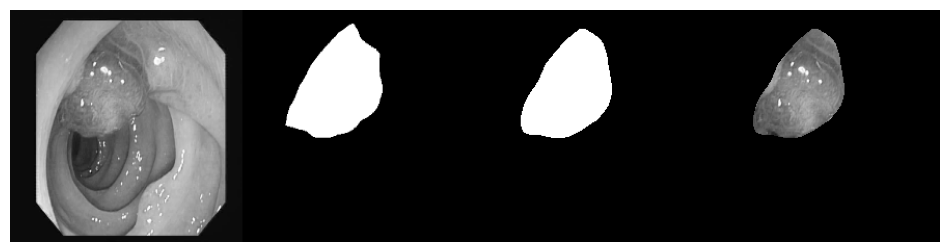

 Epoch: 31 of 100, Iter.: 46 of 46, Train Loss: 0.042648, IoU: 0.933557, Dice: 0.963301
 Epoch: 31 of 100, Iter.: 46 of 46, Valid Loss: 0.235651, IoU: 0.756261, Dice: 0.831814


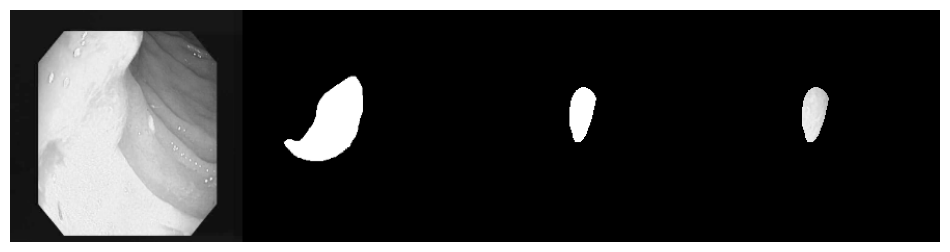

 Epoch: 32 of 100, Iter.: 46 of 46, Train Loss: 0.041418, IoU: 0.937766, Dice: 0.966989
 Epoch: 32 of 100, Iter.: 46 of 46, Valid Loss: 0.244142, IoU: 0.756943, Dice: 0.831450


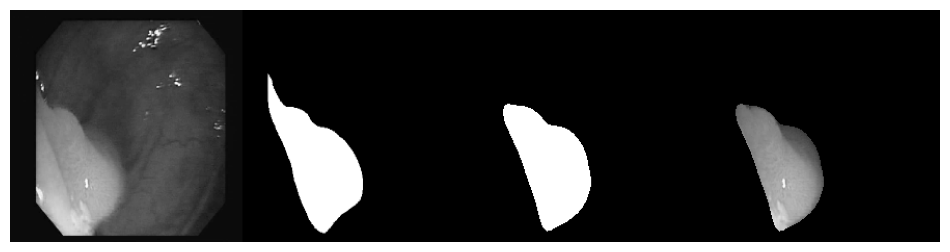

 Epoch: 33 of 100, Iter.: 46 of 46, Train Loss: 0.040364, IoU: 0.936335, Dice: 0.966068
 Epoch: 33 of 100, Iter.: 46 of 46, Valid Loss: 0.222398, IoU: 0.771271, Dice: 0.847741


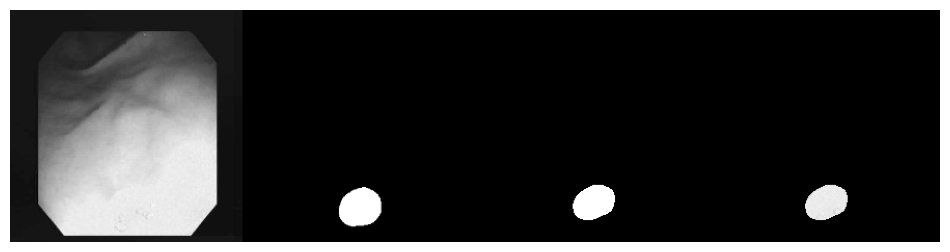

 Epoch: 34 of 100, Iter.: 46 of 46, Train Loss: 0.049916, IoU: 0.931666, Dice: 0.963330
 Epoch: 34 of 100, Iter.: 46 of 46, Valid Loss: 0.348776, IoU: 0.742484, Dice: 0.829836


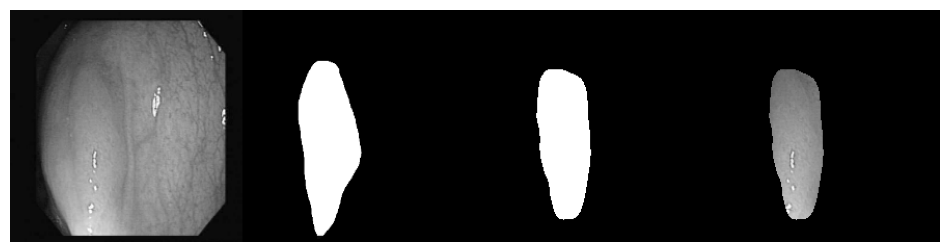

 Epoch: 35 of 100, Iter.: 46 of 46, Train Loss: 0.260885, IoU: 0.772777, Dice: 0.845888
 Epoch: 35 of 100, Iter.: 46 of 46, Valid Loss: 0.766738, IoU: 0.368017, Dice: 0.452062


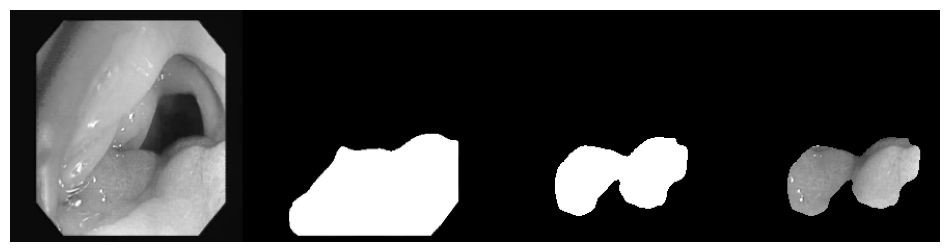

 Epoch: 36 of 100, Iter.: 46 of 46, Train Loss: 0.254835, IoU: 0.736895, Dice: 0.825481
 Epoch: 36 of 100, Iter.: 46 of 46, Valid Loss: 0.507050, IoU: 0.513910, Dice: 0.605960


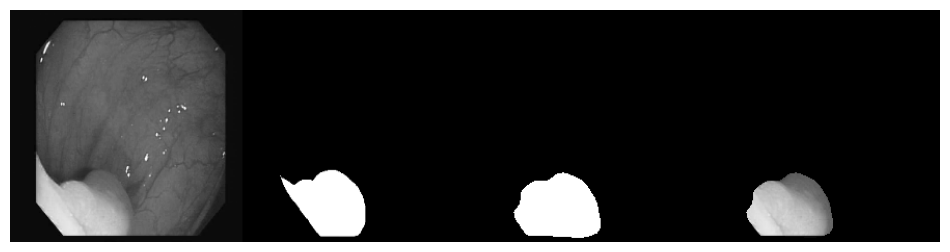

 Epoch: 37 of 100, Iter.: 46 of 46, Train Loss: 0.135897, IoU: 0.823784, Dice: 0.887849
 Epoch: 37 of 100, Iter.: 46 of 46, Valid Loss: 0.201827, IoU: 0.750740, Dice: 0.822364


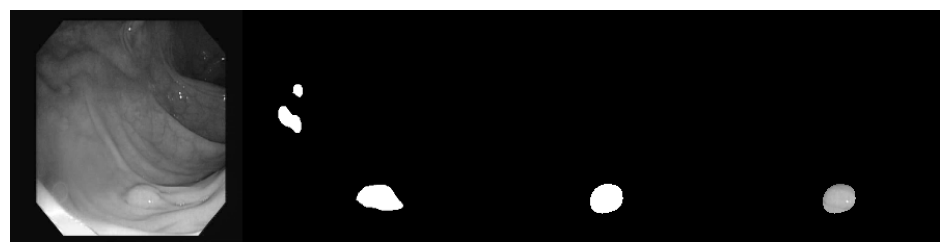

 Epoch: 38 of 100, Iter.: 46 of 46, Train Loss: 0.097533, IoU: 0.866379, Dice: 0.919256
 Epoch: 38 of 100, Iter.: 46 of 46, Valid Loss: 0.189520, IoU: 0.779017, Dice: 0.856166


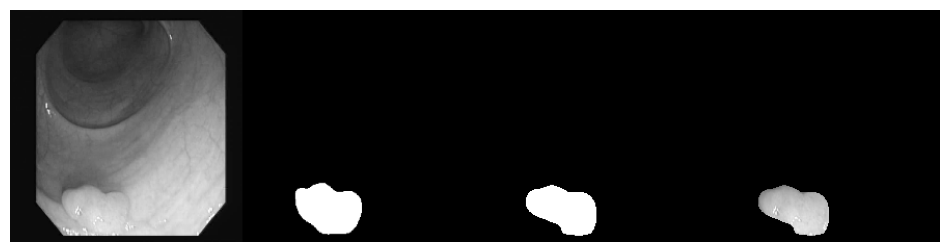

 Epoch: 39 of 100, Iter.: 46 of 46, Train Loss: 0.070670, IoU: 0.895537, Dice: 0.939900
 Epoch: 39 of 100, Iter.: 46 of 46, Valid Loss: 0.199513, IoU: 0.768557, Dice: 0.842447


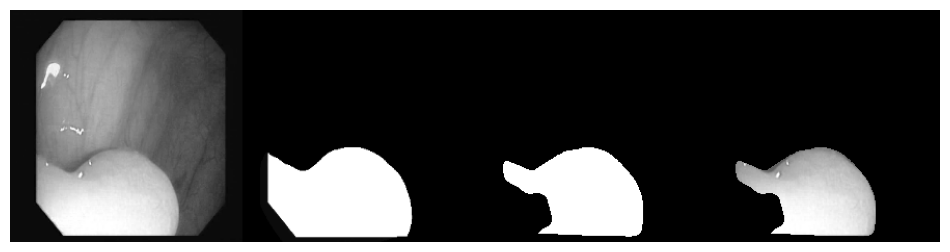

 Epoch: 40 of 100, Iter.: 46 of 46, Train Loss: 0.064552, IoU: 0.903471, Dice: 0.943599
 Epoch: 40 of 100, Iter.: 46 of 46, Valid Loss: 0.187514, IoU: 0.793179, Dice: 0.866776


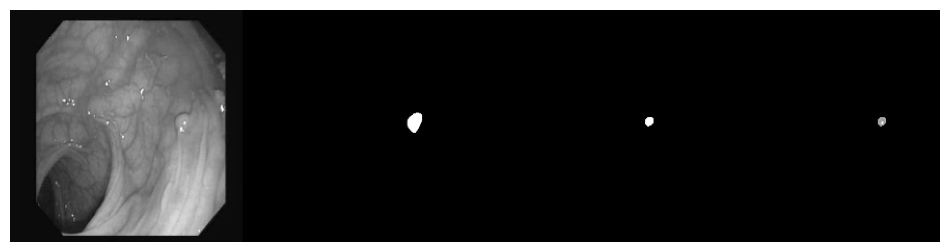

 Epoch: 41 of 100, Iter.: 46 of 46, Train Loss: 0.056336, IoU: 0.911669, Dice: 0.950111
 Epoch: 41 of 100, Iter.: 46 of 46, Valid Loss: 0.206319, IoU: 0.769479, Dice: 0.844470


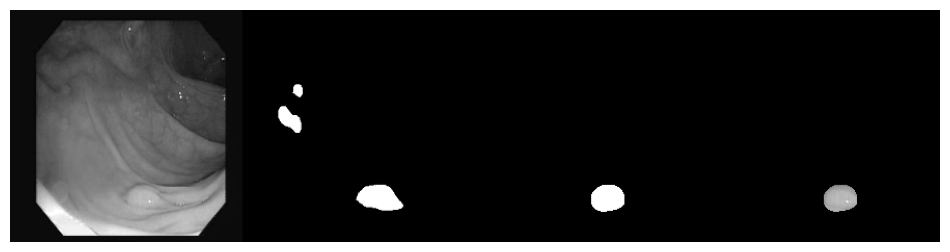

 Epoch: 42 of 100, Iter.: 46 of 46, Train Loss: 0.052846, IoU: 0.916561, Dice: 0.951699
 Epoch: 42 of 100, Iter.: 46 of 46, Valid Loss: 0.249131, IoU: 0.754393, Dice: 0.832973


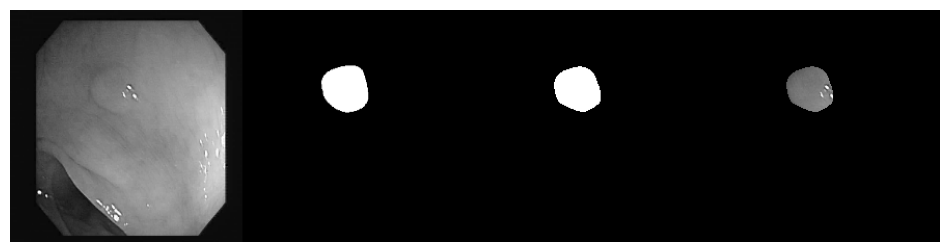

 Epoch: 43 of 100, Iter.: 46 of 46, Train Loss: 0.047572, IoU: 0.924008, Dice: 0.957046
 Epoch: 43 of 100, Iter.: 46 of 46, Valid Loss: 0.215261, IoU: 0.771022, Dice: 0.846941


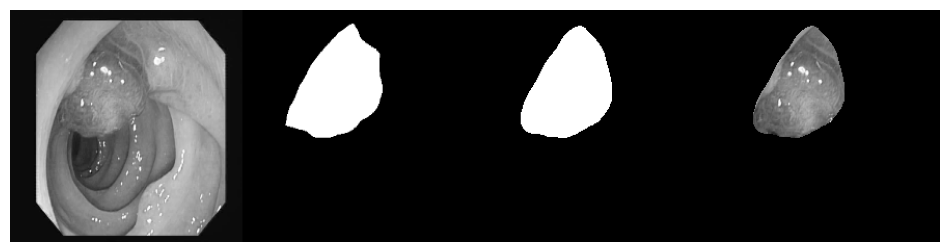

 Epoch: 44 of 100, Iter.: 46 of 46, Train Loss: 0.045502, IoU: 0.925953, Dice: 0.959306
 Epoch: 44 of 100, Iter.: 46 of 46, Valid Loss: 0.193051, IoU: 0.791834, Dice: 0.866712


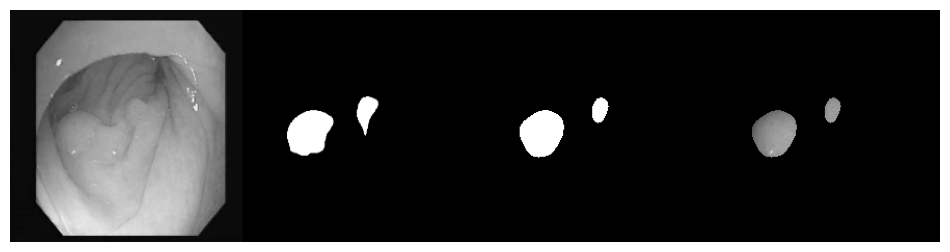

 Epoch: 45 of 100, Iter.: 46 of 46, Train Loss: 0.042740, IoU: 0.933639, Dice: 0.964699
 Epoch: 45 of 100, Iter.: 46 of 46, Valid Loss: 0.211745, IoU: 0.789541, Dice: 0.863274


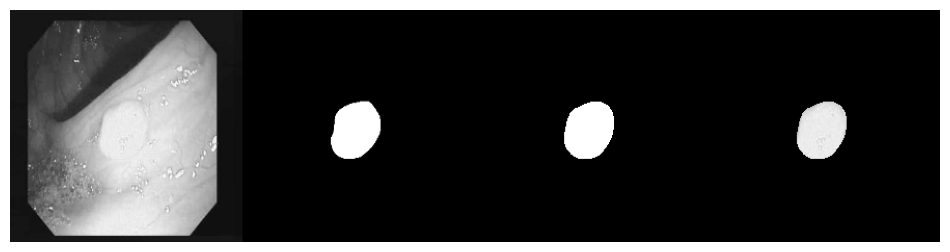

 Epoch: 46 of 100, Iter.: 46 of 46, Train Loss: 0.040697, IoU: 0.934350, Dice: 0.964738
 Epoch: 46 of 100, Iter.: 46 of 46, Valid Loss: 0.197672, IoU: 0.795378, Dice: 0.868930


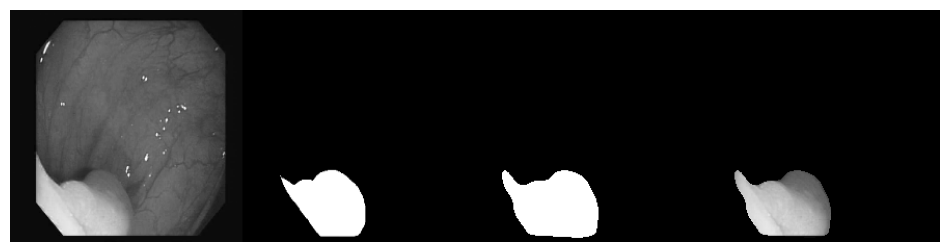

 Epoch: 47 of 100, Iter.: 46 of 46, Train Loss: 0.039070, IoU: 0.937878, Dice: 0.967178
 Epoch: 47 of 100, Iter.: 46 of 46, Valid Loss: 0.211678, IoU: 0.787857, Dice: 0.862107


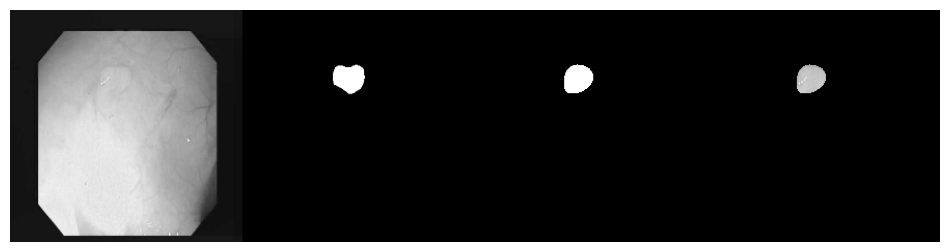

 Epoch: 48 of 100, Iter.: 46 of 46, Train Loss: 0.037343, IoU: 0.940810, Dice: 0.968837
 Epoch: 48 of 100, Iter.: 46 of 46, Valid Loss: 0.204328, IoU: 0.798084, Dice: 0.871073


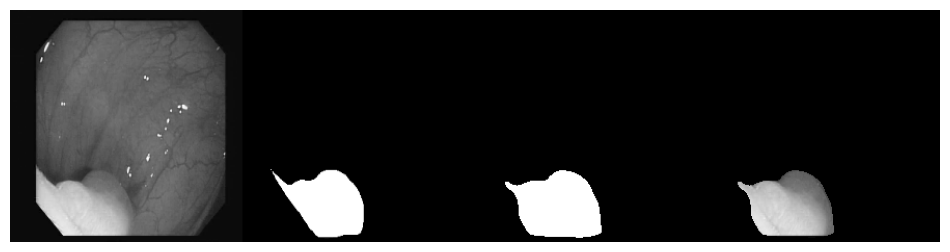

 Epoch: 49 of 100, Iter.: 46 of 46, Train Loss: 0.036426, IoU: 0.942371, Dice: 0.969457
 Epoch: 49 of 100, Iter.: 46 of 46, Valid Loss: 0.242310, IoU: 0.775838, Dice: 0.850950


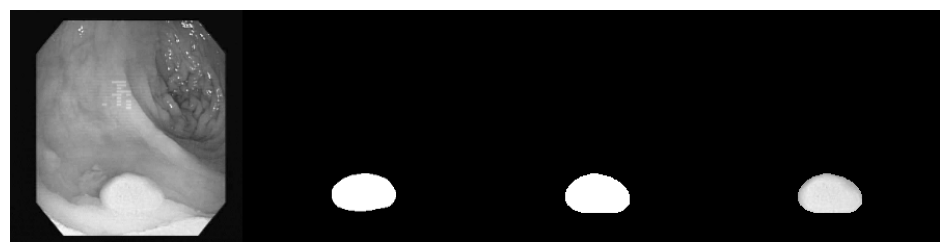

 Epoch: 50 of 100, Iter.: 46 of 46, Train Loss: 0.035895, IoU: 0.939846, Dice: 0.966707
 Epoch: 50 of 100, Iter.: 46 of 46, Valid Loss: 0.233809, IoU: 0.781110, Dice: 0.856901


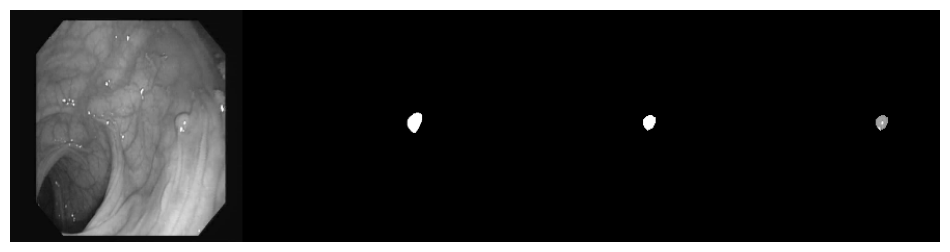

 Epoch: 51 of 100, Iter.: 46 of 46, Train Loss: 0.035470, IoU: 0.943489, Dice: 0.969582
 Epoch: 51 of 100, Iter.: 46 of 46, Valid Loss: 0.229290, IoU: 0.791362, Dice: 0.863790


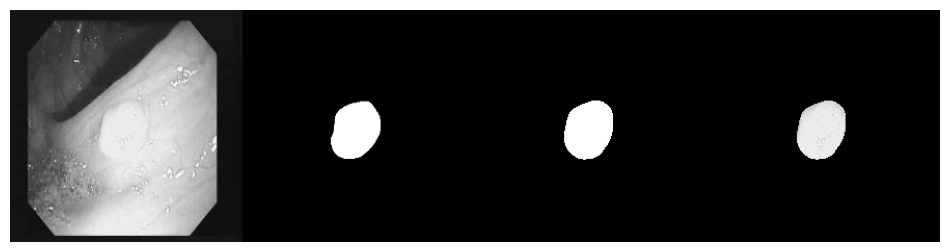

 Epoch: 52 of 100, Iter.: 46 of 46, Train Loss: 0.035025, IoU: 0.943423, Dice: 0.969785
 Epoch: 52 of 100, Iter.: 46 of 46, Valid Loss: 0.218105, IoU: 0.790724, Dice: 0.864775


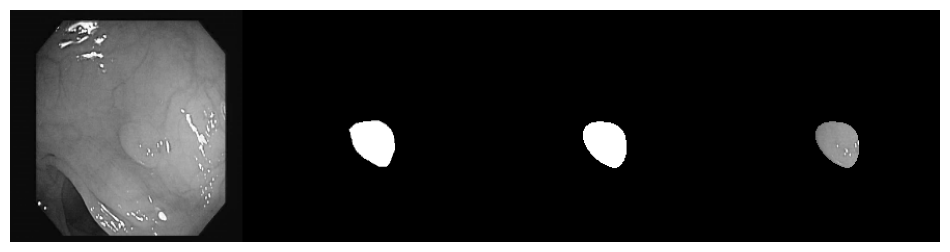

 Epoch: 53 of 100, Iter.: 46 of 46, Train Loss: 0.035766, IoU: 0.943923, Dice: 0.970530
 Epoch: 53 of 100, Iter.: 46 of 46, Valid Loss: 0.220204, IoU: 0.793420, Dice: 0.867292


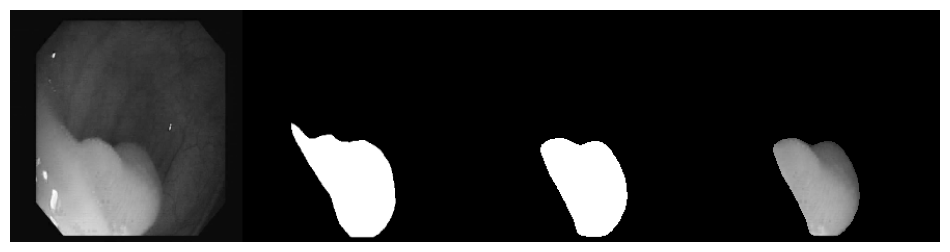

 Epoch: 54 of 100, Iter.: 46 of 46, Train Loss: 0.034564, IoU: 0.944520, Dice: 0.970238
 Epoch: 54 of 100, Iter.: 46 of 46, Valid Loss: 0.222886, IoU: 0.783843, Dice: 0.857436


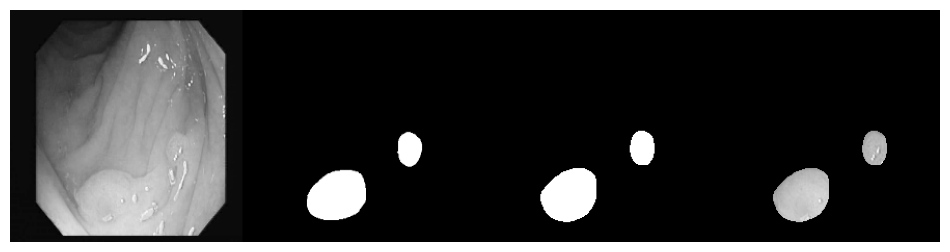

 Epoch: 55 of 100, Iter.: 46 of 46, Train Loss: 0.033534, IoU: 0.947048, Dice: 0.972313
 Epoch: 55 of 100, Iter.: 46 of 46, Valid Loss: 0.224878, IoU: 0.789845, Dice: 0.864096


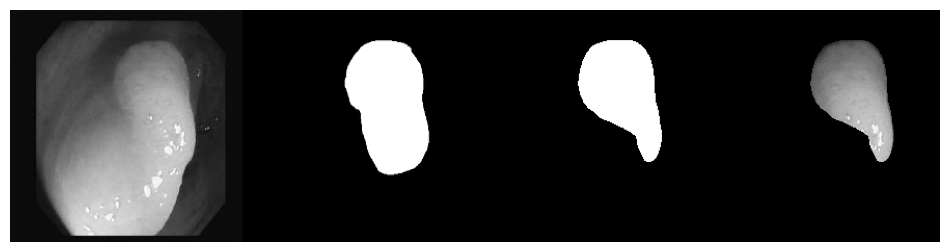

 Epoch: 56 of 100, Iter.: 46 of 46, Train Loss: 0.032645, IoU: 0.948244, Dice: 0.972989
 Epoch: 56 of 100, Iter.: 46 of 46, Valid Loss: 0.229056, IoU: 0.786184, Dice: 0.860462


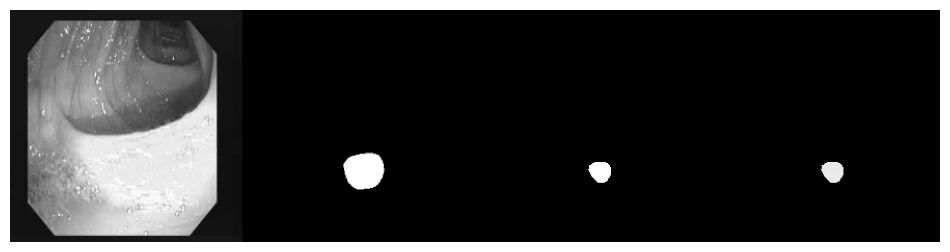

 Epoch: 57 of 100, Iter.: 46 of 46, Train Loss: 0.032066, IoU: 0.949336, Dice: 0.973462
 Epoch: 57 of 100, Iter.: 46 of 46, Valid Loss: 0.238733, IoU: 0.782821, Dice: 0.856600


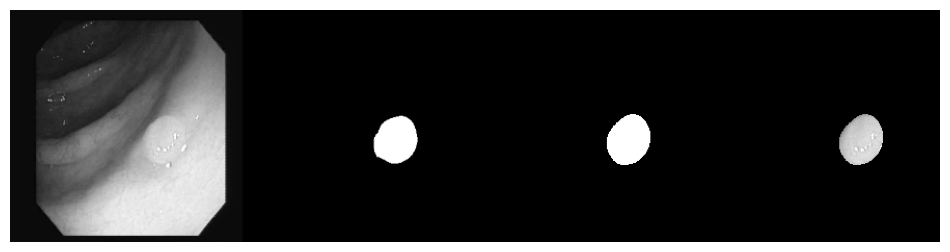

 Epoch: 58 of 100, Iter.: 46 of 46, Train Loss: 0.032088, IoU: 0.949652, Dice: 0.973780
 Epoch: 58 of 100, Iter.: 46 of 46, Valid Loss: 0.237491, IoU: 0.789347, Dice: 0.863457


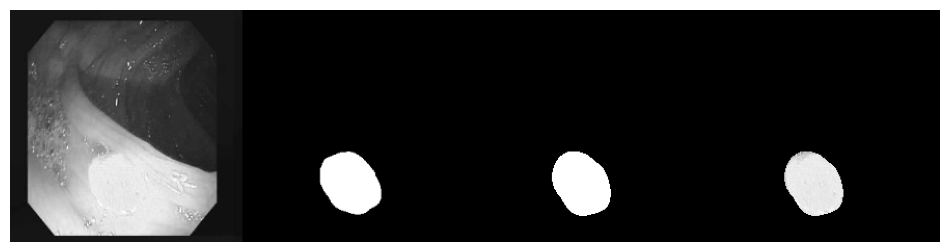

 Epoch: 59 of 100, Iter.: 46 of 46, Train Loss: 0.032588, IoU: 0.947530, Dice: 0.972314
 Epoch: 59 of 100, Iter.: 46 of 46, Valid Loss: 0.245287, IoU: 0.785932, Dice: 0.861153


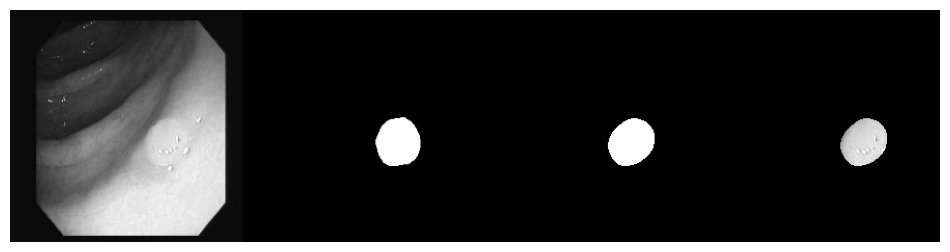

 Epoch: 60 of 100, Iter.: 46 of 46, Train Loss: 0.031307, IoU: 0.948763, Dice: 0.972879
 Epoch: 60 of 100, Iter.: 46 of 46, Valid Loss: 0.232260, IoU: 0.791496, Dice: 0.865122


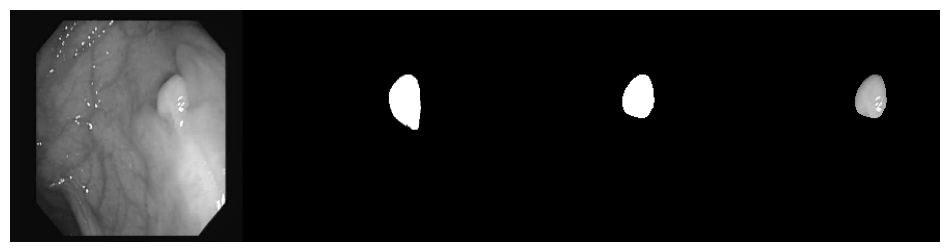

 Epoch: 61 of 100, Iter.: 46 of 46, Train Loss: 0.031114, IoU: 0.950025, Dice: 0.973848
 Epoch: 61 of 100, Iter.: 46 of 46, Valid Loss: 0.232703, IoU: 0.786749, Dice: 0.858913


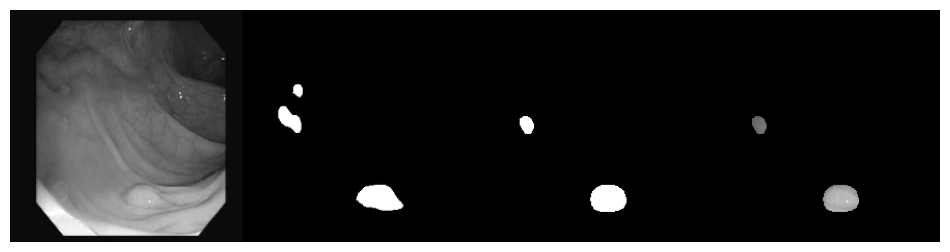

 Epoch: 62 of 100, Iter.: 46 of 46, Train Loss: 0.031683, IoU: 0.950023, Dice: 0.973958
 Epoch: 62 of 100, Iter.: 46 of 46, Valid Loss: 0.236529, IoU: 0.793144, Dice: 0.865774


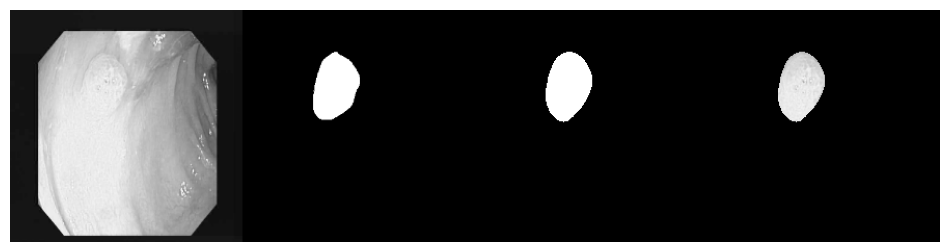

 Epoch: 63 of 100, Iter.: 46 of 46, Train Loss: 0.030819, IoU: 0.950592, Dice: 0.974238
 Epoch: 63 of 100, Iter.: 46 of 46, Valid Loss: 0.246035, IoU: 0.786722, Dice: 0.860761


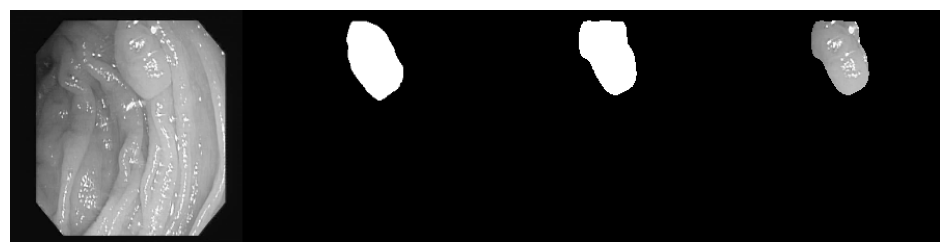

 Epoch: 64 of 100, Iter.: 46 of 46, Train Loss: 0.030402, IoU: 0.951571, Dice: 0.974799
 Epoch: 64 of 100, Iter.: 46 of 46, Valid Loss: 0.232530, IoU: 0.790051, Dice: 0.863792


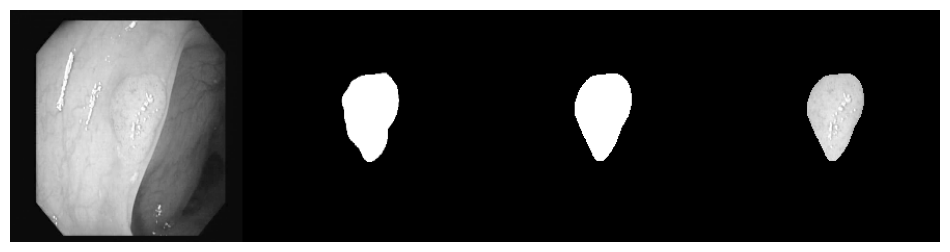

 Epoch: 65 of 100, Iter.: 46 of 46, Train Loss: 0.028995, IoU: 0.951588, Dice: 0.974537
 Epoch: 65 of 100, Iter.: 46 of 46, Valid Loss: 0.239874, IoU: 0.787778, Dice: 0.861885


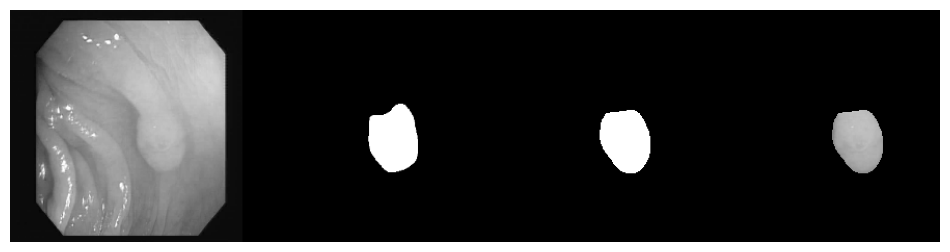

 Epoch: 66 of 100, Iter.: 46 of 46, Train Loss: 0.029622, IoU: 0.952725, Dice: 0.975363
 Epoch: 66 of 100, Iter.: 46 of 46, Valid Loss: 0.232845, IoU: 0.794573, Dice: 0.867365


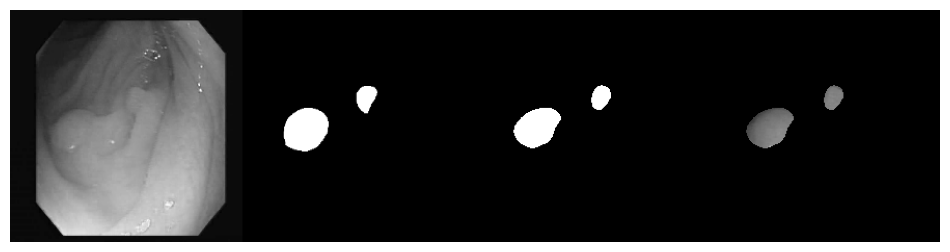

 Epoch: 67 of 100, Iter.: 46 of 46, Train Loss: 0.029812, IoU: 0.952084, Dice: 0.975089
 Epoch: 67 of 100, Iter.: 46 of 46, Valid Loss: 0.251244, IoU: 0.785396, Dice: 0.858560


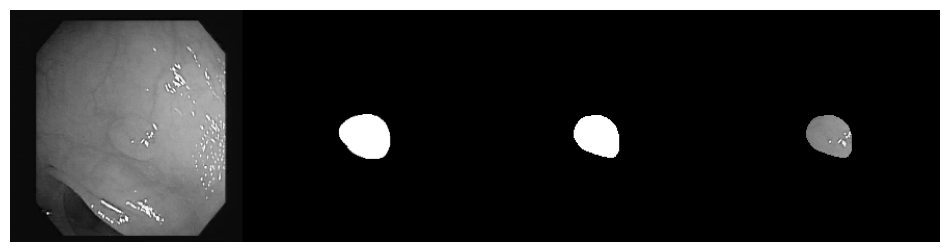

 Epoch: 68 of 100, Iter.: 46 of 46, Train Loss: 0.029704, IoU: 0.952346, Dice: 0.975215
 Epoch: 68 of 100, Iter.: 46 of 46, Valid Loss: 0.241581, IoU: 0.795375, Dice: 0.868438


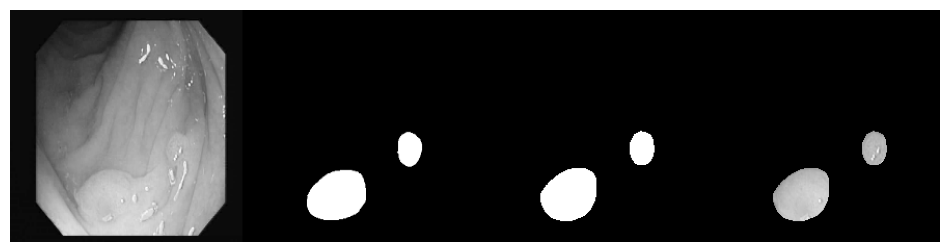

 Epoch: 69 of 100, Iter.: 46 of 46, Train Loss: 0.029485, IoU: 0.953867, Dice: 0.976038
 Epoch: 69 of 100, Iter.: 46 of 46, Valid Loss: 0.241184, IoU: 0.792747, Dice: 0.866061


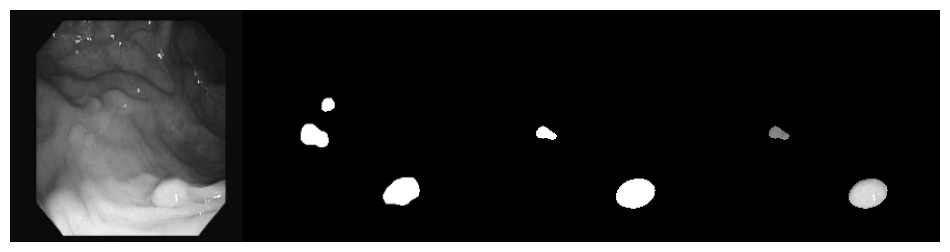


Early stopping. Target criteria has not improved for 20 epochs.

CPU times: user 6min 52s, sys: 4min 18s, total: 11min 10s
Wall time: 6min 27s


In [11]:

%%time
from ploting import plot_model_prediction

train_losses, val_losses = [], []
train_ious, val_ious = [], []
train_dices, val_dices = [], []
best_iou, best_dice, best_loss = 0, 0, np.inf
best_epoch_dice = -1
state = {}
lst_epoch_metric = []

start_time = time.time()
for epoch in range(1, epochs+1):
    running_loss, running_iou, running_dice = 0, 0, 0

    # Train
    model.train()
    for i, (imgs, masks) in enumerate(dataloader_train):
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
        
        prediction = model(imgs)
        
        optimizer.zero_grad()
        loss = criterion(prediction, masks)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        running_iou += iou_pytorch_eval(prediction, masks)
        running_dice += dice_pytorch_eval(prediction, masks)
        print("\r Epoch: {} of {}, Iter.: {} of {}, Loss: {:.6f}, IoU:  {:.6f},  Dice:  {:.6f}".format(epoch, epochs, i, len(dataloader_train), running_loss/(i+1), running_iou/(i+1), running_dice/(i+1)), end="")
        
    # Validate
    model.eval()
    val_loss, val_iou, val_dice = 0, 0, 0
    for i, (imgs, masks) in enumerate(dataloader_val):
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
        
        prediction = model(imgs)
        loss = criterion(prediction, masks)
        val_loss += loss.item()
        print("\r Epoch: {} of {}, Iter.: {} of {}, Loss: {:.6f}, Val. Loss: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), running_loss/len(dataloader_train), val_loss/(i+1)), end="")
        
        val_iou += iou_pytorch_eval(prediction, masks)
        print("\r Epoch: {} of {}, Iter.: {} of {}, IoU: {:.6f}, Val. IoU: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), running_iou/len(dataloader_train), val_iou/(i+1)), end="")

        val_dice += dice_pytorch_eval(prediction, masks)
        print("\r Epoch: {} of {}, Iter.: {} of {}, Dice: {:.6f}, Val. Dice: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), running_dice/len(dataloader_train), val_dice/(i+1)), end="")
    
    
    # compute overall epoch losses
    epoch_train_loss = running_loss/len(dataloader_train)
    train_losses.append(epoch_train_loss)
    epoch_val_loss = val_loss/len(dataloader_val)
    val_losses.append(epoch_val_loss)

    # compute overall epoch iou-s
    epoch_train_iou = (running_iou/len(dataloader_train)).item()
    train_ious.append(epoch_train_iou)
    epoch_val_iou = (val_iou/len(dataloader_val)).item()
    val_ious.append(epoch_val_iou)
    
    # compute overall epoch dice
    epoch_train_dice = (running_dice/len(dataloader_train)).item()
    train_dices.append(epoch_train_dice)
    epoch_val_dice = (val_dice/len(dataloader_val)).item()
    val_dices.append(epoch_val_dice)

    print("\r Epoch: {} of {}, Iter.: {} of {}, Train Loss: {:.6f}, IoU: {:.6f}, Dice: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), epoch_train_loss, epoch_train_iou, epoch_train_dice))
    print("\r Epoch: {} of {}, Iter.: {} of {}, Valid Loss: {:.6f}, IoU: {:.6f}, Dice: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), epoch_val_loss, epoch_val_iou, epoch_val_dice))
    if epoch == 1:
        print('\n시각화되는 이미지는 1.실제 테스트 이미지 2.실제 라벨 이미지 3.예측 라벨 4.예측한 이미지 결과의 순서입니다.')
    plot_model_prediction(model, DEVICE, valid_images, valid_labels)
        
    # plot
    metrics = {'loss':[train_losses, epoch_train_loss, val_losses, epoch_val_loss],
               'Iou':[train_ious, epoch_train_iou, val_ious,  epoch_val_iou],
               'Dice':[train_dices, epoch_train_dice, val_dices,  epoch_val_dice]}
    
    lst_epoch_metric.append([round(epoch_train_loss,4), round(epoch_train_iou,4), round(epoch_train_dice,4), 
                             round(epoch_val_loss,4), round(epoch_val_iou,4), round(epoch_val_dice,4)]) 

    # save if best results or break is has not improved for {patience} number of epochs
    best_iou = max(best_iou, epoch_val_iou)
    best_dice = max(best_dice, epoch_val_dice)
    best_loss = min(best_loss, epoch_val_loss)
    best_epoch_dice = epoch if best_dice == epoch_val_dice else best_epoch_dice

    # record losses
    state['train_losses'] = train_losses
    state['val_losses'] = val_losses
    
    if best_epoch_dice == epoch:
        # print('Saving..')
        state['net'] = model.state_dict()
        state['dice'] = best_dice
        state['epoch'] = epoch
            
        if not os.path.isdir('checkpoints'):
            os.mkdir('checkpoints')
        torch.save(state, f'./checkpoints/ckpt_{model_name}_{data_name}.pth')
    
    
    elif best_epoch_dice + patience < epoch:
        print(f"\nEarly stopping. Target criteria has not improved for {patience} epochs.\n")
        break

file_name = f'{model_name}_{data_name}'
# load once more and write all the losses down (othw can miss the last 10)
end_time = time.time() - start_time

state = torch.load(f'./checkpoints/ckpt_{model_name}_{data_name}.pth')
state['train_losses'] = train_losses
state['val_losses'] = val_losses
torch.save(state, f'./checkpoints/ckpt_{model_name}_{data_name}.pth')

df_epoch_metric = pd.DataFrame(lst_epoch_metric, columns = ['epoch_train_loss', 'epoch_val_loss', 'epoch_train_iou', 'epoch_val_iou', 'epoch_train_dice', 'epoch_val_dice'])
df_epoch_metric.to_csv(f'/project/segmentation/smcho1201/training_{model_name}/csv_{file_name}.csv', index_label = ['epoch'])

Validationset 기준 
Best_epoch:48, Best_IOU:0.7981, Best_DiceScore:0.8711


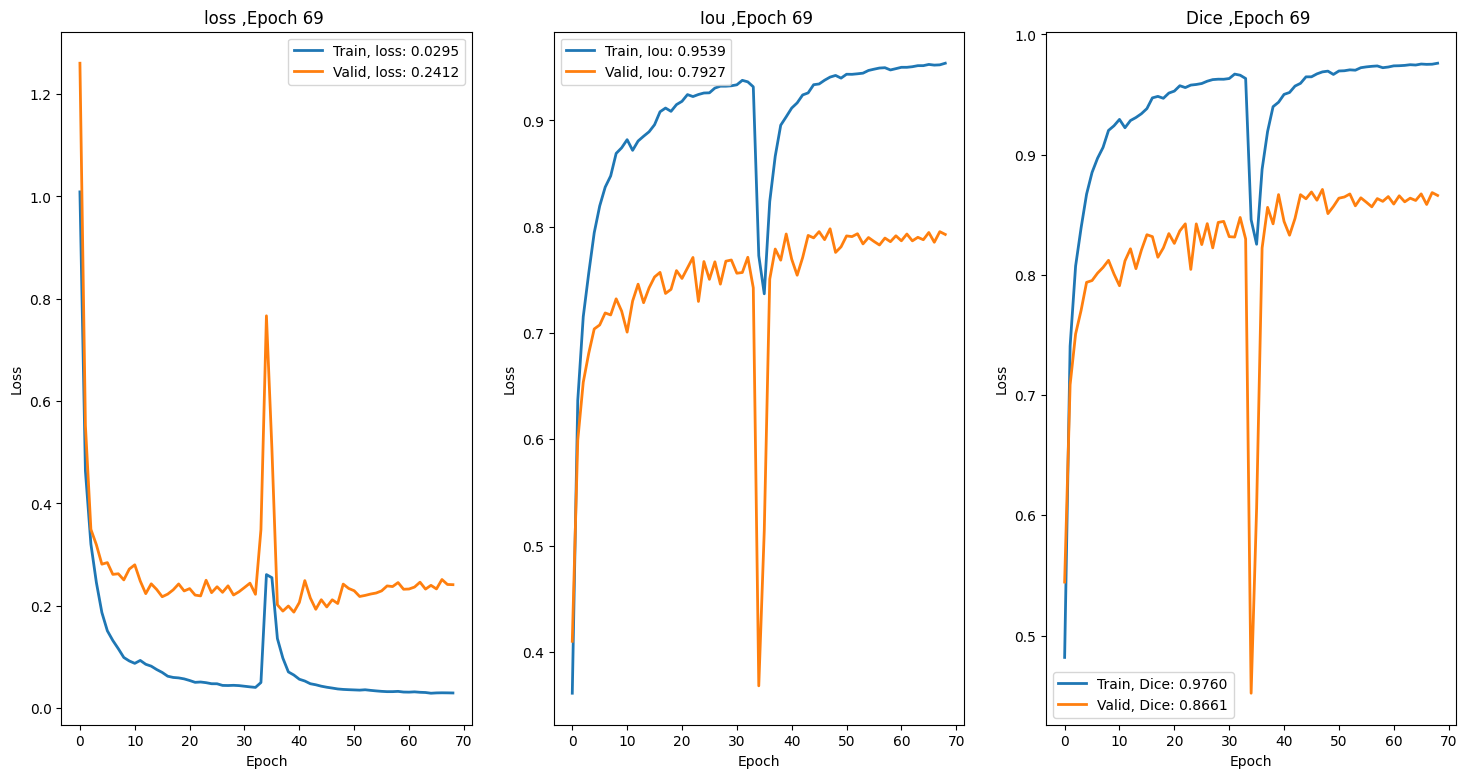

In [12]:
print(f'Validationset 기준 \nBest_epoch:{best_epoch_dice}, Best_IOU:{best_iou:.4f}, Best_DiceScore:{best_dice:.4f}')

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 9))           
for i, (metric, value) in enumerate(metrics.items()):
    axs[i].plot(np.arange(len(value[0])), value[0], label=f'Train, {metric}: {value[1]:.4f}', linewidth=2)
    axs[i].plot(np.arange(len(value[2])), value[2], label=f'Valid, {metric}: {value[3]:.4f}', linewidth=2)
    axs[i].set_xlabel('Epoch')
    axs[i].set_ylabel('Loss')
    axs[i].set_title(f'{metric} ,Epoch {epoch} ')
    axs[i].legend(loc='best')
plt.show()